In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from matplotlib import colors,cm
from scipy import stats
import dispersion_utils as utils
from datetime import timedelta, date
import os
import pandas as pd
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import sys

In [2]:
home_folder = "/nethome/manra003/analysis/dispersion/simulations/"
output_folder = "/nethome/manra003/analysis/dispersion/outputs/"

min_lat, max_lat = -35, -15
min_lon, max_lon = 10, 20

months = [str(x).zfill(2) for x in range(1,13)]
years = [2021]#np.arange(2010,2022)

dvm_types=['2D'] #, 'DVM', 'DVM_d']
compare_modes=['3D'] #, '3D', 'sinking']
dvm_type_labels=['2D']#['DVM I' ,'DVM II', 'DVM III']

p_total = 104636    #total number of particles per simulation
t_days = 100  #length of simulation in days
threshold_dist = 100    # km-  mesoscale

In [4]:
coords = pd.read_csv('/nethome/manra003/atlanteco_plankton_plastic_nutrients_dispersion/data/Benguela_release_points_1ov32_641x_321ygrid.csv')

cutoff_index= np.min(np.where(coords['Latitude']>-26)[0])
cutoff_index

67242

In [5]:
# 0-67242- southern section from -35 to -26
p_total-cutoff_index

37394

In [32]:
def get_separation_array(ds1, ds2, p_total, t_days):
    '''
    Method to get per particle pair distance between two types for each day opf the simulation
    parameters: ds1, ds2-two datasets; p_total-total number of particles; t_days-total number of outputs(per day) in the simulation 
    return: an array with horizontal separation distance between two types of particles for the same release.
    '''
    sep_array_1_2 = np.empty((p_total, t_days))
    sep_array_1_2[:] = np.nan
    for time_step in range(t_days):
        sep_array_1_2[:, time_step] = utils.distance(ds1['lon'][:, time_step], ds1['lat'][:, time_step], ds2['lon'][:, time_step], ds2['lat'][:, time_step])
    return sep_array_1_2


In [39]:
all_sep_array = np.empty((p_total, t_days, len(months)))
all_CDFs = np.zeros((len(months), t_days+1))
north_all_CDFs = np.zeros((len(months), t_days+1))
south_all_CDFs = np.zeros((len(months), t_days+1))

north_indices=()

for dvm_mode in dvm_types:
    for mode in compare_modes:
        distance_folder = output_folder + "Distances/{0}-{1}/".format(dvm_mode, mode)
        if not os.path.exists(distance_folder):
            os.makedirs(distance_folder)
        cdf_folder = output_folder + "CDF/{0}-{1}/".format(dvm_mode, mode)
        if not os.path.exists(cdf_folder):
            os.makedirs(cdf_folder)
        for year in years:
            
            print("Summary {0}-{1} for all months: {2}".format(dvm_mode, mode, year))

            # Get monthly CDF from 100 days simulation.
            for index, month in enumerate(months):
                ds1 = xr.open_zarr(home_folder + '{0}/{1}/Benguela_{0}_1ov32_641x_321yres_{1}-{2}_5z_100days.zarr'.format(dvm_mode, year, month))
                ds2 = xr.open_zarr(home_folder + '{0}/{1}/Benguela_{0}_1ov32_641x_321yres_{1}-{2}_5z_100days.zarr'.format(mode, year, month))

                # assert files are similar
                assert len(ds1.trajectory) == len(ds2.trajectory)
                assert len(ds1.obs) ==100 or len(ds1.obs) ==101
                assert len(ds2.obs) ==100 or len(ds2.obs) ==101  
                all_sep_array[:, :, index] = get_separation_array(ds1, ds2, p_total, t_days)
                all_CDFs[index, :], _ = utils.get_diff_CDF_PDF(all_sep_array[:, :, index], threshold_dist, t_days)
                
                north_all_CDFs[index, :], _ = utils.get_diff_CDF_PDF(all_sep_array[:67242, :, index], threshold_dist, t_days)
                south_all_CDFs[index, :], _ = utils.get_diff_CDF_PDF(all_sep_array[67242:, :, index], threshold_dist, t_days)
            
            # np.save(distance_folder+"all_sep_array_{0}_{1}_{2}_tc{3}km.npy".format(dvm_mode, mode, year, threshold_dist), all_sep_array)
            # np.save(cdf_folder+"all_CDF_{0}_{1}_{2}_tc{3}km.npy".format(dvm_mode, mode, year, threshold_dist), all_CDFs)
            # sys.stdout.flush()

Summary 2D-3D for all months: 2021


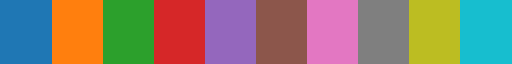

In [34]:
dpi = 100
# color = cm.YlGnBu #
color = cm.magma_r
scatter_size = .3

spring_ind = [8, 9, 10]
summer_ind = [11, 0, 1]
autumn_ind = [2, 3, 4]
winter_ind = [5, 6, 7]
cmap = plt.get_cmap('tab10')
new_cmap = colors.ListedColormap(cmap(np.arange(10)))
new_cmap

In [35]:
def plot_mean_std(ax, cdfs, l, c, text_size=12):
    sigma =1
    mean = np.nanmean(cdfs, axis=0)
    std = np.nanstd(cdfs, axis=0)
    ax.plot(mean, label=l, color=c)
    # ax.plot(mean - sigma*std, linestyle = '--', linewidth = 0.8, color=c)
    # ax.plot(mean + sigma*std, linestyle = '--', linewidth = 0.8, color=c)
    ax.fill_between(np.arange(0, 100), mean - sigma*std, mean + sigma*std, alpha=0.2)
    ax.tick_params(axis='both', labelsize=text_size)
    ax.axhline(y=0.5, c='darkgray', xmin=0, xmax=100, linewidth=2, linestyle='--', zorder=-1)


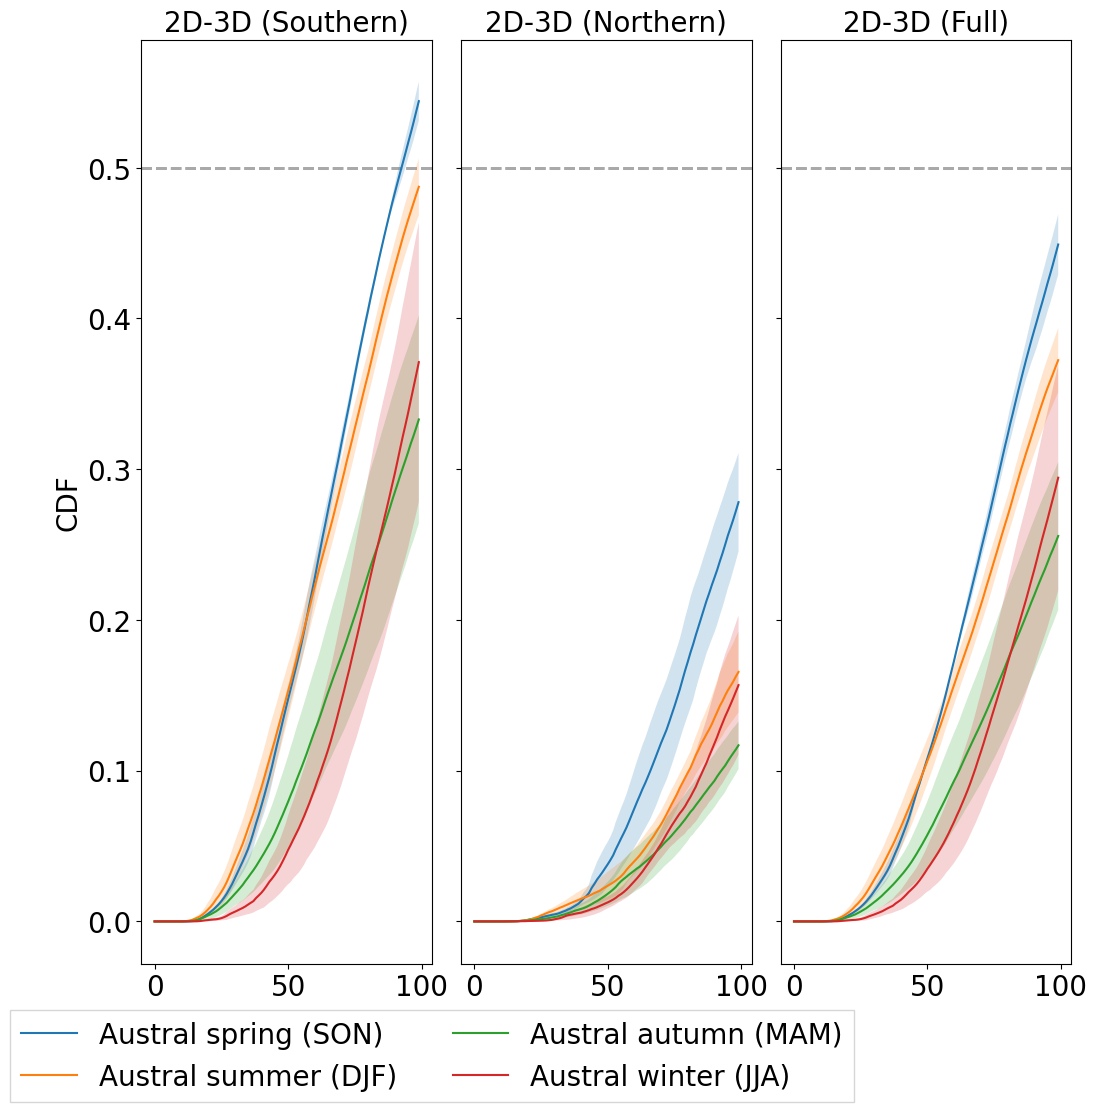

In [45]:
text_size=20 # for print- size = 24, or size 15
spring_cdf = np.zeros((len(years)*3, t_days))
summer_cdf = np.zeros(spring_cdf.shape)
autumn_cdf = np.zeros(spring_cdf.shape)
winter_cdf = np.zeros(spring_cdf.shape)

fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12,12), dpi=dpi)
cdf_data= north_all_CDFs
index=0
spring_cdf[index*3:index*3+3, :] = cdf_data[spring_ind, :t_days]
summer_cdf[index*3:index*3+3, :] = cdf_data[summer_ind, :t_days]
autumn_cdf[index*3:index*3+3, :] = cdf_data[autumn_ind, :t_days]
winter_cdf[index*3:index*3+3, :] = cdf_data[winter_ind, :t_days]
i=0
plot_mean_std(axs[i], spring_cdf, "Austral spring (SON)",new_cmap(0), text_size)
plot_mean_std(axs[i], summer_cdf, "Austral summer (DJF)",new_cmap(1), text_size)
plot_mean_std(axs[i], autumn_cdf, "Austral autumn (MAM)",new_cmap(2), text_size)
plot_mean_std(axs[i], winter_cdf, "Austral winter (JJA)",new_cmap(3), text_size) 
axs[i].set_title(str(dvm_type_labels[i]+'-'+mode+' (Southern)'), fontsize=text_size)

cdf_data= south_all_CDFs
index =0
spring_cdf[index*3:index*3+3, :] = cdf_data[spring_ind, :t_days]
summer_cdf[index*3:index*3+3, :] = cdf_data[summer_ind, :t_days]
autumn_cdf[index*3:index*3+3, :] = cdf_data[autumn_ind, :t_days]
winter_cdf[index*3:index*3+3, :] = cdf_data[winter_ind, :t_days]
i=1
plot_mean_std(axs[i], spring_cdf, "Austral spring (SON)",new_cmap(0), text_size)
plot_mean_std(axs[i], summer_cdf, "Austral summer (DJF)",new_cmap(1), text_size)
plot_mean_std(axs[i], autumn_cdf, "Austral autumn (MAM)",new_cmap(2), text_size)
plot_mean_std(axs[i], winter_cdf, "Austral winter (JJA)",new_cmap(3), text_size) 
axs[i].set_title(str(dvm_type_labels[0]+'-'+mode+' (Northern)'), fontsize=text_size)

cdf_data= all_CDFs
index==0
spring_cdf[index*3:index*3+3, :] = cdf_data[spring_ind, :t_days]
summer_cdf[index*3:index*3+3, :] = cdf_data[summer_ind, :t_days]
autumn_cdf[index*3:index*3+3, :] = cdf_data[autumn_ind, :t_days]
winter_cdf[index*3:index*3+3, :] = cdf_data[winter_ind, :t_days]
i=2
plot_mean_std(axs[i], spring_cdf, "Austral spring (SON)",new_cmap(0), text_size)
plot_mean_std(axs[i], summer_cdf, "Austral summer (DJF)",new_cmap(1), text_size)
plot_mean_std(axs[i], autumn_cdf, "Austral autumn (MAM)",new_cmap(2), text_size)
plot_mean_std(axs[i], winter_cdf, "Austral winter (JJA)",new_cmap(3), text_size) 
axs[i].set_title(str(dvm_type_labels[0]+'-'+mode+' (Full)'), fontsize=text_size)

axs[0].set_ylabel("CDF", fontsize=text_size)
axs[0].legend(loc='center', fontsize=text_size, bbox_to_anchor=(1, -0.1),fancybox=False, shadow=False, ncol=2)

# axs[0][0].set_ylim(-0.01,1.01)
plt.subplots_adjust(hspace=0.15, wspace=0.1)